## Gesture Recognition Assignment

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:


* Thumbs Up:	Increase the volume.
* Thumbs Down:	Decrease the volume.
* Left Swipe:	'Jump' backwards 10 seconds.
* Right Swipe:	'Jump' forward 10 seconds.
* Stop:	Pause the movie.

Each video is a sequence of 30 frames (or images).

#### Objectives:
1. <b>Generator:</b> The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. <b>Model:</b> Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. <b>Write up:</b> This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
# Importing the required libraries
import numpy as np
from imageio import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
# Importing the other required libraries
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
from cv2 import resize
tf.random.set_seed(30)

In [3]:
# Importing the other required libraries
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# importing some other libraries which will be needed for model building.
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [5]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [6]:
# build the class to process the generator functionality
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=imresize(image,(self.image_height,self.image_width,3))
                image_resized=resize(image,(self.image_height,self.image_width))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    #image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    image_resized=resize(cropped,(self.image_height,self.image_width))
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### Sample Test Model

In [8]:
# model class to process the model building logic
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [7]:
# create variable for access the dataset
project_folder='/Users/rsah/Downloads/Assignment/Project_data'

In [10]:
# Procss the model class logic
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

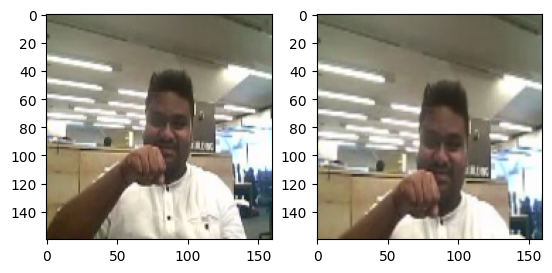

In [11]:
# fetch the data for test
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

### Model 1
##### Base Model - Batch Size = 64 and No. of Epochs = 25, No. Of Frames =15 & Image Size = 160*160

In [12]:
# model class to process the model building logic
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
# Procss the model class logic
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=64,num_epochs=25)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_54 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 7, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 7, 80, 80, 32)     13856     
                                                                 
 activation_41 (Activation)  (None, 7, 80, 80, 32)   

In [39]:
# Execute the model
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.7578 - categorical_accuracy: 0.3982 
Epoch 1: val_loss improved from inf to 1.57444, saving model to model_init_2023-03-1914_24_23.442076/model-00001-1.75777-0.39819-1.57444-0.26000.h5
11/11 [==============================] - 189s 17s/step - loss: 1.7578 - categorical_accuracy: 0.3982 - val_loss: 1.5744 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.0822 - categorical_accuracy: 0.5716 
Epoch 2: val_loss did not improve from 1.57444
11/11 [==============================] - 185s 17s/step - loss: 1.0822 - categorical_accuracy: 0.5716 - val_loss: 1.6490 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.8482 - categorical_accuracy: 0.6742 
Epoch 3: val_loss did not improve from 1.57444
11/11 [==============================] - 182s 17s/step - loss: 0.8482 - categor

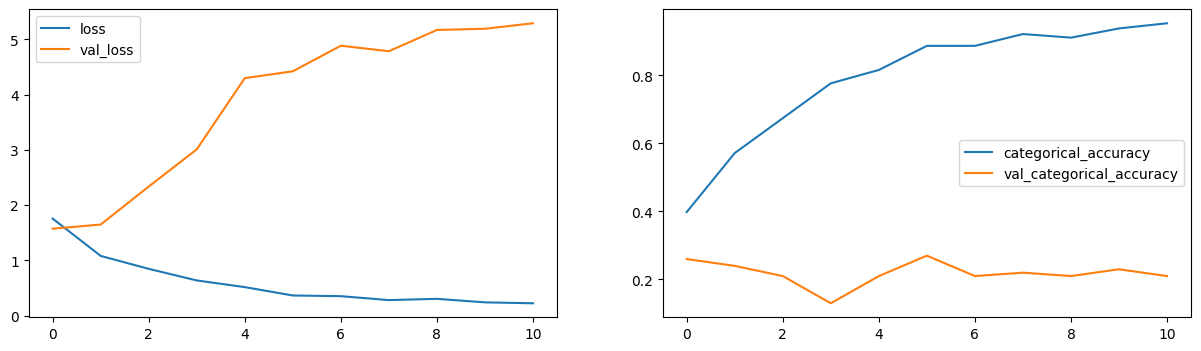

In [41]:
# Plot the model output
plot(history_model1)

<b> The model graph is clearly showing overfitting.</b>

### Model 2
##### Change the Model Parameters- Batch Size = 64 and No. of Epochs = 25, No. Of Frames =30 & Image Size = 160*160

In [42]:
# Process the model class logic
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=64,num_epochs=25)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_60 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_42 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_45 (Activation)  (None, 15, 80, 80, 32)  

In [43]:
# Execute the model
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1936261
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.6467 - categorical_accuracy: 0.4223 
Epoch 1: val_loss improved from inf to 1.60475, saving model to model_init_2023-03-1915_06_18.223707/model-00001-1.64670-0.42232-1.60475-0.24000.h5
11/11 [==============================] - 427s 38s/step - loss: 1.6467 - categorical_accuracy: 0.4223 - val_loss: 1.6048 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.0360 - categorical_accuracy: 0.5882 
Epoch 2: val_loss did not improve from 1.60475
11/11 [==============================] - 411s 37s/step - loss: 1.0360 - categorical_accuracy: 0.5882 - val_loss: 3.0483 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.7584 - categorical_accuracy: 0.7270 
Epoch 3: val_loss did not improve from 1.60475
11/11 [==============================] - 404s 37s/step - loss: 0.7584 - categor

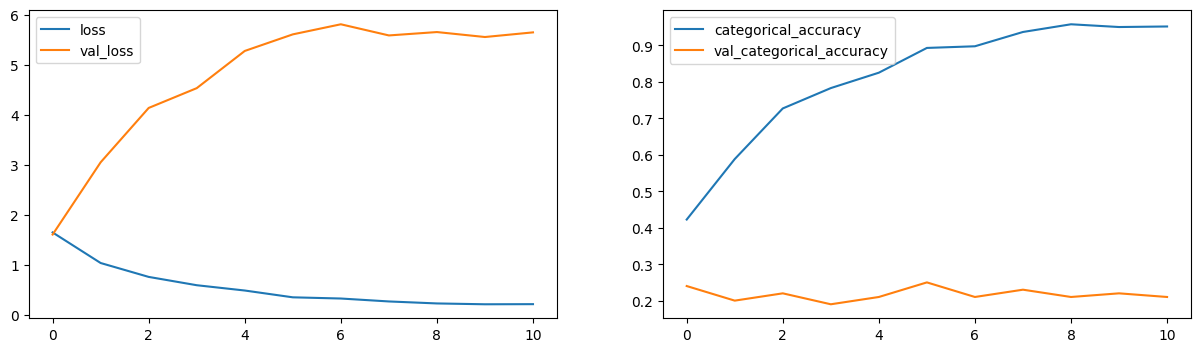

In [44]:
# Plot the model output
plot(history_model1)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Model 3
##### Change the Model Parameters - Batch Size = 64 and No. of Epochs = 25, No. Of Frames =15 & Image Size = 320*320

In [13]:
# Process the model class logic
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=320,image_width=320)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=64,num_epochs=25)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 320, 320, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 15, 320, 320, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 15, 320, 320, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 160, 160, 16)  0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 7, 160, 160, 32)   13856     
                                                                 
 activation_5 (Activation)   (None, 7, 160, 160, 32)  

In [14]:
# Execute the model
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 3574661
Epoch 1/25


2023-03-19 16:31:52.223623: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - ETA: 0s - loss: 1.7121 - categorical_accuracy: 0.3484  
Epoch 1: val_loss improved from inf to 1.96912, saving model to model_init_2023-03-1916_31_49.204410/model-00001-1.71215-0.34842-1.96912-0.27000.h5
11/11 [==============================] - 878s 80s/step - loss: 1.7121 - categorical_accuracy: 0.3484 - val_loss: 1.9691 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.0259 - categorical_accuracy: 0.5928  
Epoch 2: val_loss improved from 1.96912 to 1.77943, saving model to model_init_2023-03-1916_31_49.204410/model-00002-1.02590-0.59276-1.77943-0.18000.h5
11/11 [==============================] - 819s 74s/step - loss: 1.0259 - categorical_accuracy: 0.5928 - val_loss: 1.7794 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.8002 - categorical_accuracy: 0.6893  
Epoch 3: val_loss improved from 1.77943 to 1.66425,

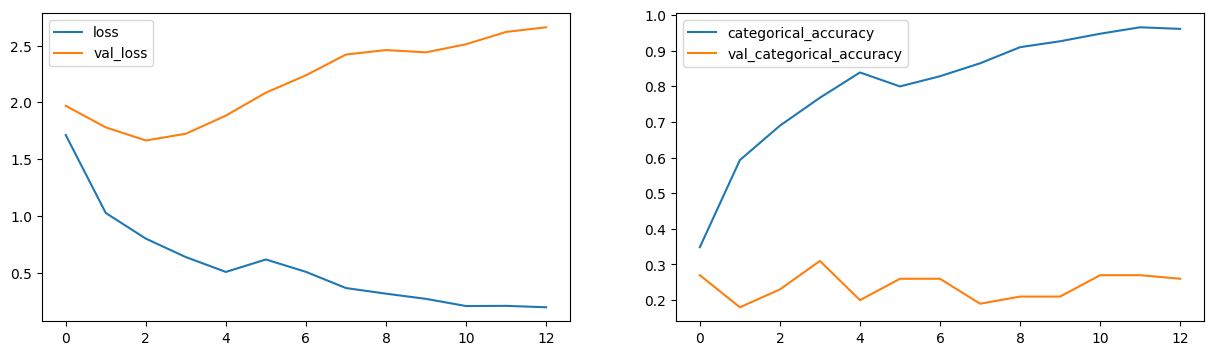

In [15]:
# Plot the model output
plot(history_model1)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Model 4
##### Change the Model Parameters & Add Dropout - Batch Size = 20 and No. of Epochs = 25, No. Of Frames =15, Image Size = 160*160 & Dropout = .4

In [18]:
# Process the model class logic
conv_3d4=ModelConv3D1()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=160,image_width=160)
conv_3d4.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(dense_neurons=256, dropout=0.4)
conv_3d4_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 80, 80, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 7, 80, 80, 32)    

In [19]:
# Execute the model
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8499 - categorical_accuracy: 0.3974 
Epoch 1: val_loss improved from inf to 2.51708, saving model to model_init_2023-03-1920_07_14.152429/model-00001-1.84991-0.39744-2.51708-0.18000.h5
34/34 [==============================] - 357s 10s/step - loss: 1.8499 - categorical_accuracy: 0.3974 - val_loss: 2.5171 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4154 - categorical_accuracy: 0.5098 
Epoch 2: val_loss did not improve from 2.51708
34/34 [==============================] - 355s 10s/step - loss: 1.4154 - categorical_accuracy: 0.5098 - val_loss: 3.7317 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0829 - categorical_accuracy: 0.6146 
Epoch 3: val_loss did not improve from 2.51708
34/34 [==============================] - 357s 10s/step - loss: 1.0829 - categor

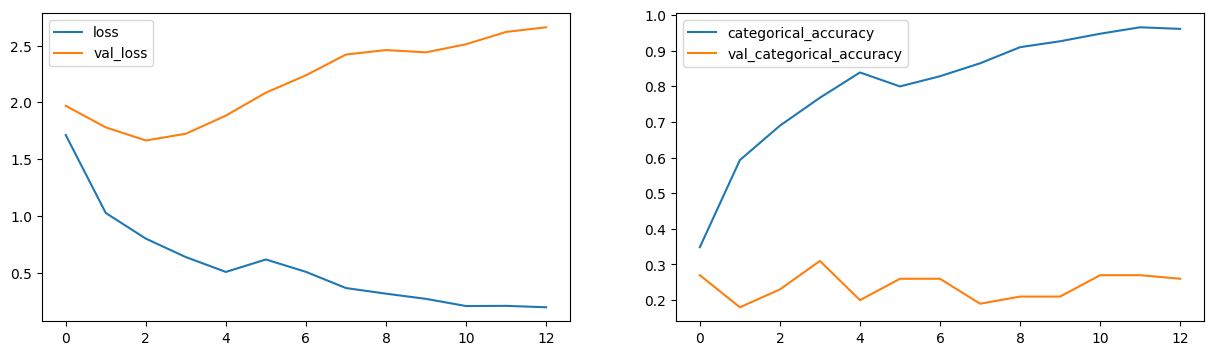

In [20]:
# Plot the model output
plot(history_model1)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Model 5
##### Change the Model Parameters & add Dropout - Filter Size = (2,2,2), Batch Size = 24 and No. of Epochs = 25, No. Of Frames =15, Image Size = 160*160 & Dropout = 0.5

In [21]:
# model class to process the model building logic
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [22]:
# Process the model class logic
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=160,image_width=160)
conv_3d5.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
conv_3d5_model=conv_3d5.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d5_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 15, 160, 160, 16)  400       
                                                                 
 activation_16 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 7, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 7, 80, 80, 32)     4128      
                                                                 
 activation_17 (Activation)  (None, 7, 80, 80, 32)    

In [23]:
# Execute the model
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 3433781


Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.8305 - categorical_accuracy: 0.4155
Epoch 1: val_loss improved from inf to 2.96393, saving model to model_init_2023-03-1922_35_05.654095/model-00001-1.83052-0.41554-2.96393-0.16000.h5
28/28 [==============================] - 245s 9s/step - loss: 1.8305 - categorical_accuracy: 0.4155 - val_loss: 2.9639 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.2162 - categorical_accuracy: 0.5807
Epoch 2: val_loss did not improve from 2.96393
28/28 [==============================] - 242s 9s/step - loss: 1.2162 - categorical_accuracy: 0.5807 - val_loss: 5.0734 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 0.9259 - categorical_accuracy: 0.6682
Epoch 3: val_loss did not improve from 2.96393
28/28 [==============================] - 243s 9s/step - loss: 0.9259 - categorical_accuracy: 0.6682 - val_

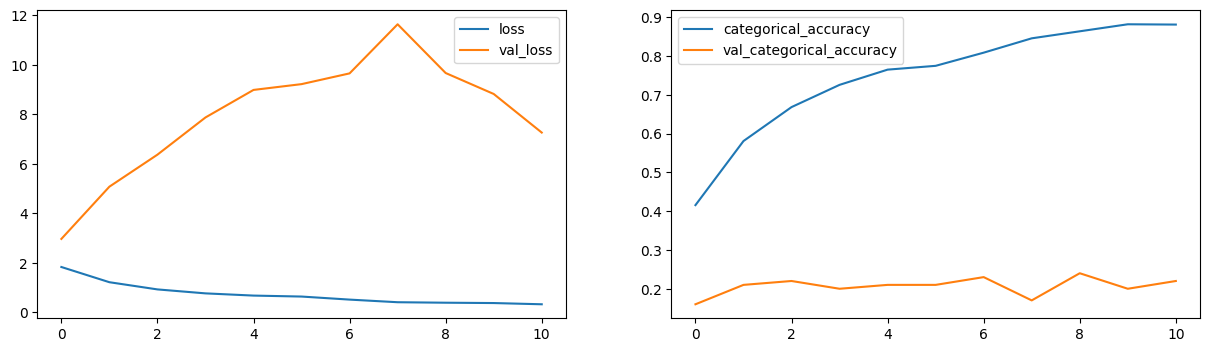

In [24]:
# Plot the model output
plot(history_model5)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Model 6
##### Change the Model Parameters & add Dropout - Adding more layers, Batch Size = 24 and No. of Epochs = 25, No. Of Frames =15, Image Size = 160*160 & Dropout = 0.5

In [25]:
# model class to process the model building logic
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
# Process the model class logic
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=160,image_width=160)
conv_3d6.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
conv_3d6_model=conv_3d6.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d6_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_29 (Conv3D)          (None, 15, 160, 160, 16)  6928      
                                                                 
 activation_29 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                     

In [36]:
# Execute the model
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 4227701


Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.9716 - categorical_accuracy: 0.3884 
Epoch 1: val_loss improved from inf to 1.78167, saving model to model_init_2023-03-2000_42_17.049134/model-00001-1.97162-0.38839-1.78167-0.21000.h5
28/28 [==============================] - 718s 26s/step - loss: 1.9716 - categorical_accuracy: 0.3884 - val_loss: 1.7817 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.4388 - categorical_accuracy: 0.5083 
Epoch 2: val_loss did not improve from 1.78167
28/28 [==============================] - 719s 26s/step - loss: 1.4388 - categorical_accuracy: 0.5083 - val_loss: 3.4225 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 1.1419 - categorical_accuracy: 0.6003 
Epoch 3: val_loss did not improve from 1.78167
28/28 [==============================] - 716s 26s/step - loss: 1.1419 - categorical_accuracy: 0.6003 

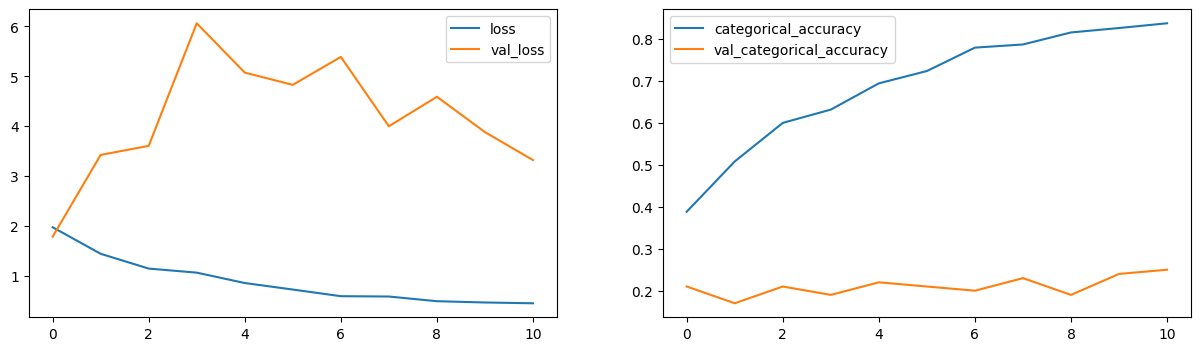

In [37]:
# Plot the model output
plot(history_model6)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Model 7
##### Change the Model Parameters & add Dropout - Adding Dropout at Convolution Layers, Batch Size = 24 and No. of Epochs = 25, No. Of Frames =15, Image Size = 160*160 & Dropout = 0.25

In [12]:
# model class to process the model building logic
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
# Process the model class logic
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=160,image_width=160)
conv_3d7.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 15, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 160, 160, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 15, 160, 160, 16)  64       
 hNormalization)                                        

In [14]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 4227701
Epoch 1/25


2023-03-20 12:45:56.633370: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


28/28 [==============================] - ETA: 0s - loss: 1.7570 - categorical_accuracy: 0.3884 
Epoch 1: val_loss improved from inf to 1.53329, saving model to model_init_2023-03-2012_45_55.358693/model-00001-1.75700-0.38839-1.53329-0.32000.h5
28/28 [==============================] - 716s 25s/step - loss: 1.7570 - categorical_accuracy: 0.3884 - val_loss: 1.5333 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.2329 - categorical_accuracy: 0.5430 
Epoch 2: val_loss did not improve from 1.53329
28/28 [==============================] - 717s 26s/step - loss: 1.2329 - categorical_accuracy: 0.5430 - val_loss: 2.7383 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 1.0522 - categorical_accuracy: 0.5890 
Epoch 3: val_loss did not improve from 1.53329
28/28 [==============================] - 723s 26s/step - loss: 1.0522 - categorical_accuracy: 0.5890 - val_loss:

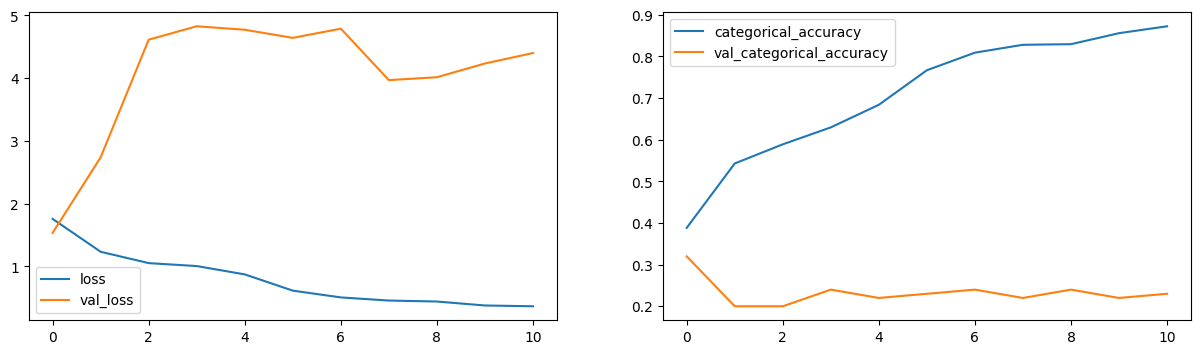

In [15]:
plot(history_model7)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Model 8
##### Change the Model Parameters & add Dropout - Reduce the Number of Parameters, Batch Size = 24 and No. of Epochs = 25, No. Of Frames =15, Image Size = 160*160 & Dropout = 0.25

In [16]:
# model class to process the model building logic
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
# Process the model class logic
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=160,image_width=160)
conv_3d8.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 7, 80, 80, 32)     13856     
                                                                 
 activation_9 (Activation)   (None, 7, 80, 80, 32)    

In [18]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 922501
Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.6017 - categorical_accuracy: 0.4080 
Epoch 1: val_loss improved from inf to 1.69336, saving model to model_init_2023-03-2015_09_39.093465/model-00001-1.60171-0.40799-1.69336-0.22000.h5
28/28 [==============================] - 347s 12s/step - loss: 1.6017 - categorical_accuracy: 0.4080 - val_loss: 1.6934 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.0827 - categorical_accuracy: 0.5754 
Epoch 2: val_loss did not improve from 1.69336
28/28 [==============================] - 344s 12s/step - loss: 1.0827 - categorical_accuracy: 0.5754 - val_loss: 2.1353 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 0.8366 - categorical_accuracy: 0.6742 
Epoch 3: val_loss did not improve from 1.69336
28/28 [==============================] - 339s 12s/step - loss: 0.8366 - 

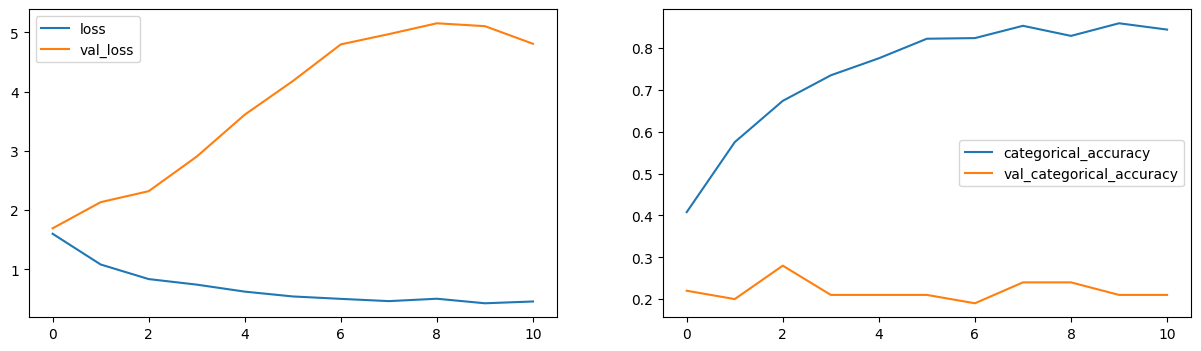

In [19]:
plot(history_model8)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Model 9
### CNN-LSTM & Data Augmentation Model

##### CNN-LSTM Model - Batch Size = 64 and No. of Epochs = 25, No. Of Frames =15 & Image Size = 160*160 dropout=0.25

In [20]:
# model class to process the model building logic
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
       
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
# Process the model class logic
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=160,image_width=160)
rnn_cnn1.initialize_hyperparams(frames_to_sample=15,batch_size=64,num_epochs=25)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 15, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 15, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 15, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 15, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 15, 80, 80, 32)  

In [28]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 3754597
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.3872 - categorical_accuracy: 0.3944 
Epoch 1: val_loss improved from inf to 1.54934, saving model to model_init_2023-03-2017_12_16.994264/model-00001-1.38715-0.39442-1.54934-0.33000.h5
11/11 [==============================] - 131s 11s/step - loss: 1.3872 - categorical_accuracy: 0.3944 - val_loss: 1.5493 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.0913 - categorical_accuracy: 0.5762 
Epoch 2: val_loss did not improve from 1.54934
11/11 [==============================] - 133s 12s/step - loss: 1.0913 - categorical_accuracy: 0.5762 - val_loss: 1.6605 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.8833 - categorical_accuracy: 0.6848 
Epoch 3: val_loss did not improve from 1.54934
11/11 [==============================] - 137s 12s/step - loss: 0.8833 - categor

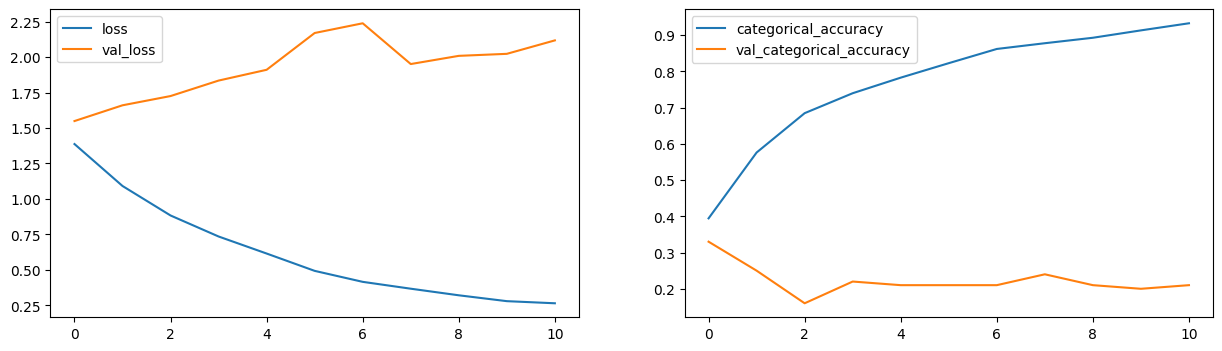

In [30]:
plot(history_model9)

<b> Once again, the model graph is clearly showing overfitting.</b>

### Data Augmentation

In [8]:
# build the class to process the generator functionality with Data Augmentation
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### Model 10
##### Model - With Data Augmentation, Batch Size = 24 and No. of Epochs = 25, No. Of Frames =15 & Image Size = 160*160 dropout=0.5

In [34]:
# model class to process the model building logic
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2) , padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
# Process the model class logic
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_31 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 7, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 80, 80, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 7, 80, 80, 32)    

In [37]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.8920 - categorical_accuracy: 0.3884 
Epoch 1: saving model to model_init_2023-03-2018_01_59.945904/model-00001-1.89198-0.38839-1.81605-0.16000.h5
28/28 [==============================] - 363s 13s/step - loss: 1.8920 - categorical_accuracy: 0.3884 - val_loss: 1.8160 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.2986 - categorical_accuracy: 0.5347 
Epoch 2: saving model to model_init_2023-03-2018_01_59.945904/model-00002-1.29858-0.53469-2.96754-0.16000.h5
28/28 [==============================] - 362s 13s/step - loss: 1.2986 - categorical_accuracy: 0.5347 - val_loss: 2.9675 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 1.1546 - categorical_accuracy: 0.5958 
Epoch 3: saving model to model_init_2023-03-2018_01_59.945904/model-00003-1.15464-0.59578-3.877

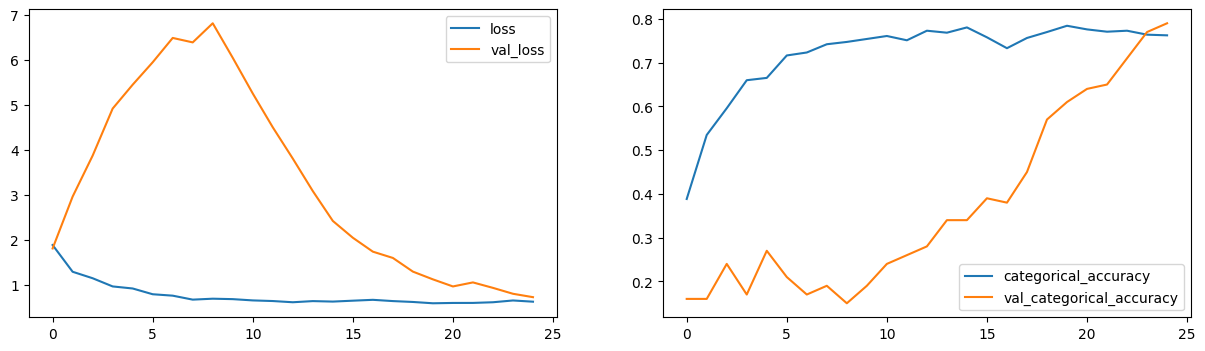

In [38]:
plot(history_model10)

#### We can see the val_loss improvement!!!
#### The best weights save automatically. The validation accuracy of 76% and training accuracy of 76% at last stage of epoch

### Model 11
##### Change the Model Parameters & add Dropout - With Data Augmentation & (2,2,2) Filter, Batch Size = 24 and No. of Epochs = 25, No. Of Frames =15, Image Size = 160*160 & Dropout = 0.5

In [9]:
# model class to process the model building logic
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
# Process the model class logic
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=160,image_width=160)
conv_3d11.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 160, 160, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 15, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 7, 80, 80, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 7, 80, 80, 32)    

In [13]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 3433781
Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.9624 - categorical_accuracy: 0.3575
Epoch 1: saving model to model_init_2023-03-2022_01_27.868275/model-00001-1.96243-0.35747-1.97322-0.21000.h5
28/28 [==============================] - 243s 9s/step - loss: 1.9624 - categorical_accuracy: 0.3575 - val_loss: 1.9732 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.3085 - categorical_accuracy: 0.5573
Epoch 2: saving model to model_init_2023-03-2022_01_27.868275/model-00002-1.30848-0.55732-3.00902-0.18000.h5
28/28 [==============================] - 239s 9s/step - loss: 1.3085 - categorical_accuracy: 0.5573 - val_loss: 3.0090 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 1.1400 - categorical_accuracy: 0.6116
Epoch 3: saving model to model_init_2023-03-2022_01_27.868275/model-00003-1.14003-0.61161-3.66220-0.

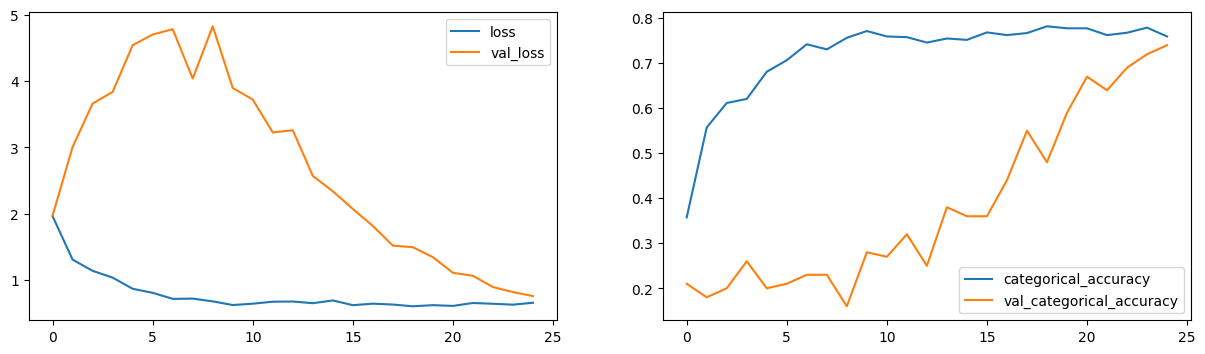

In [14]:
plot(history_model11)

<b> Once again, this model perform really well.</b>

### Model 12
##### Change the Model Parameters & add Dropout - With Data Augmentation & Reduce the Number of Parameters, Batch Size = 24 and No. of Epochs = 25, No. Of Frames =15, Image Size = 160*160 & Dropout = 0.25

In [15]:
# model class to process the model building logic
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
# Process the model class logic
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=160,image_width=160)
conv_3d12.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(dense_neurons=64,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 15, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 15, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 7, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 7, 80, 80, 32)     13856     
                                                                 
 activation_9 (Activation)   (None, 7, 80, 80, 32)    

In [17]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 922501
Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.7516 - categorical_accuracy: 0.3394 
Epoch 1: saving model to model_init_2023-03-2023_50_14.464625/model-00001-1.75156-0.33937-1.84703-0.21000.h5
28/28 [==============================] - 352s 13s/step - loss: 1.7516 - categorical_accuracy: 0.3394 - val_loss: 1.8470 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.1931 - categorical_accuracy: 0.5407 
Epoch 2: saving model to model_init_2023-03-2023_50_14.464625/model-00002-1.19313-0.54072-2.38378-0.19000.h5
28/28 [==============================] - 349s 12s/step - loss: 1.1931 - categorical_accuracy: 0.5407 - val_loss: 2.3838 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 0.9628 - categorical_accuracy: 0.6244 
Epoch 3: saving model to model_init_2023-03-2023_50_14.464625/model-00003-0.96283-0.62443-3.4843

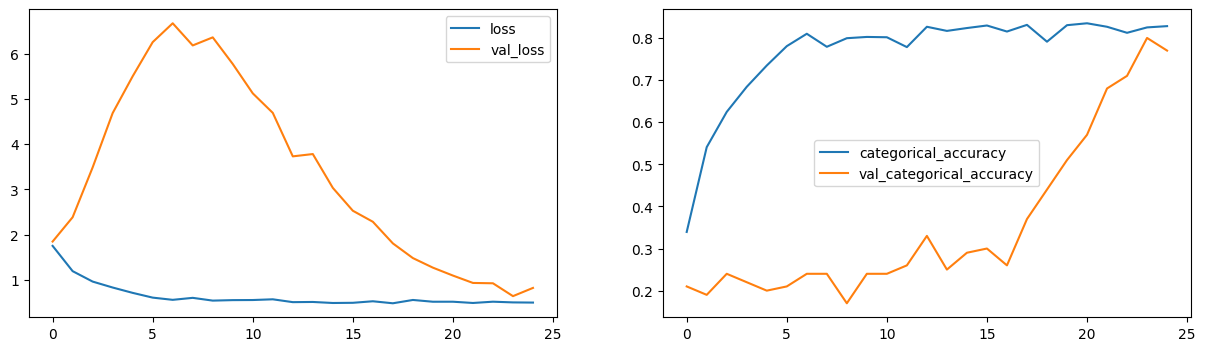

In [18]:
plot(history_model12)

<b>Once again, this model perform really well looking good </b>

### Model 13
##### CNN-LSTM with GRU Model - Batch Size = 64 and No. of Epochs = 25, No. Of Frames =15 & Image Size = 160*160 dropout=0.25

In [19]:
# model class to process the model building logic
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
# Process the model class logic
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=160,image_width=160)
rnn_cnn2.initialize_hyperparams(frames_to_sample=15,batch_size=24,num_epochs=25)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 160, 160, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 160, 160, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 80, 80, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 80, 80, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 80, 80, 32)  

In [21]:
# Execute the model
print("Total Params:", rnn_cnn2_model.count_params())
history_model13=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 5080677
Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.4584 - categorical_accuracy: 0.3778
Epoch 1: saving model to model_init_2023-03-2108_59_56.291839/model-00001-1.45842-0.37783-1.65214-0.25000.h5
28/28 [==============================] - 90s 3s/step - loss: 1.4584 - categorical_accuracy: 0.3778 - val_loss: 1.6521 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/25
28/28 [==============================] - ETA: 0s - loss: 1.0405 - categorical_accuracy: 0.5897
Epoch 2: saving model to model_init_2023-03-2108_59_56.291839/model-00002-1.04055-0.58974-2.16998-0.25000.h5
28/28 [==============================] - 87s 3s/step - loss: 1.0405 - categorical_accuracy: 0.5897 - val_loss: 2.1700 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 3/25
28/28 [==============================] - ETA: 0s - loss: 0.8588 - categorical_accuracy: 0.6765
Epoch 3: saving model to model_init_2023-03-2108_59_56.291839/model-00003-0.85877-0.67647-2.41340-0.28

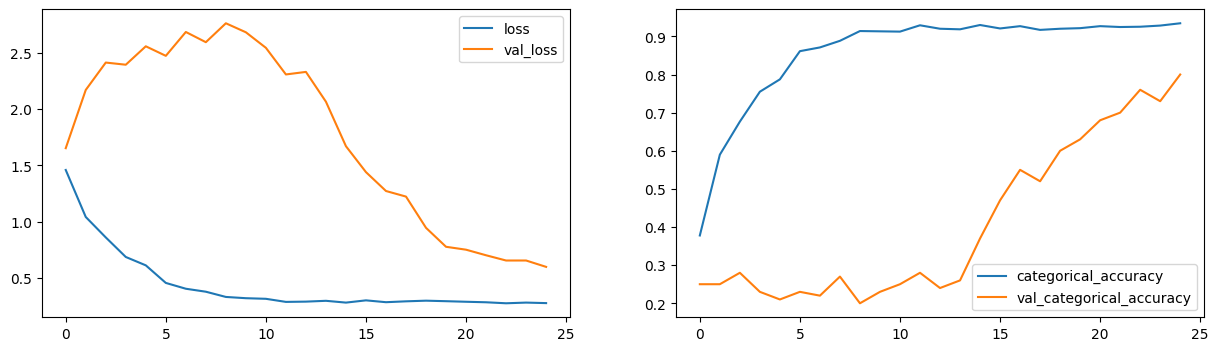

In [22]:
# Plot the model output
plot(history_model13)

</b> Once again, this model perform really well, This model need more number of epoch to get the good outcome </b>

### Model 14
#### Change the Model Parameters & add Dropout - Transfer Learning with GRU and training all weights
#### With Data Augmentation, Batch Size = 5 and No. of Epochs = 20, No. Of Frames =15, Image Size = 120*120 & Dropout = 0.25

In [25]:
# model class to process the model building logic
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
# Process the model class logic
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [33]:
# Execute the model
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253


Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1239 - categorical_accuracy: 0.5588
Epoch 1: saving model to model_init_2023-03-1923_43_48.801607/model-00001-1.12389-0.55882-0.56694-0.74000.h5
133/133 [==============================] - 165s 1s/step - loss: 1.1239 - categorical_accuracy: 0.5588 - val_loss: 0.5669 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.5863 - categorical_accuracy: 0.7775
Epoch 2: saving model to model_init_2023-03-1923_43_48.801607/model-00002-0.58631-0.77753-0.40673-0.87000.h5
133/133 [==============================] - 175s 1s/step - loss: 0.5863 - categorical_accuracy: 0.7775 - val_loss: 0.4067 - val_categorical_accuracy: 0.8700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4543 - categorical_accuracy: 0.8348
Epoch 3: saving model to model_init_2023-03-1923_43_48.801607/model-00003-0.45434-0.83484-0.25986-0.91000.h5
133/133 [==

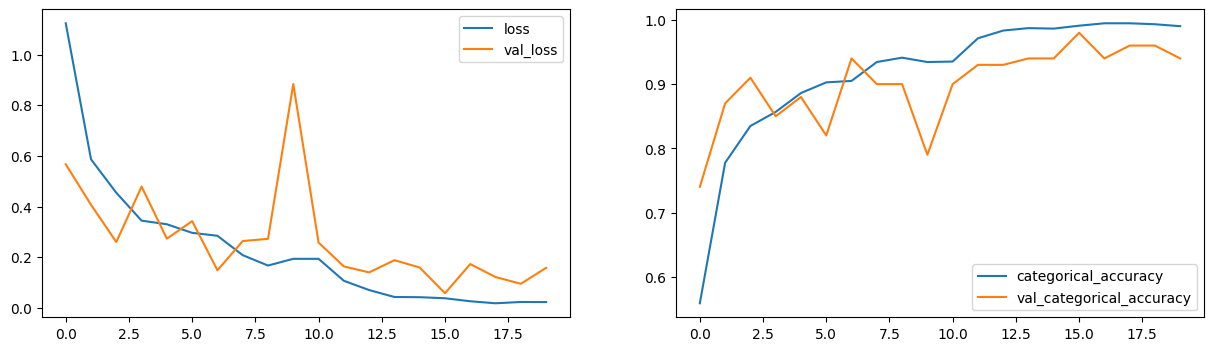

In [34]:
# Plot the model output
plot(history_model19)

### <b> This is one of best model provided very high accuracy 99% for training and 98% for validation </b>

We finalized Model 14 - Transfer Learning with GRU, which performed really very well.

- (Training Accuracy : 99%, Validation Accuracy : 98%)

- Number of Parameters(36,93,253) is ok compare to other models performance


Let's have look the performance on unseen data below

## Loading model and Testing

In [28]:
# importing the required libraries and load the best performing model
import time
from keras.models import load_model
model = load_model('model_init_2023-03-1923_43_48.801607/model-00016-0.03752-0.99095-0.05748-0.98000.h5')

In [29]:
# Process the model class logic to get the data for testing
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [30]:
# original label from test dataset 
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
# Predicted output label
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 1s 841ms/step
[1 1 2 0 1]
